# 00 Import Library

In [1]:
# !pip install pyemd

In [2]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger_eng')

In [3]:
import pandas as pd
import numpy as np
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from deep_translator import GoogleTranslator

# Stopword Removal & Stemming (Bahasa Indonesia)
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import stanza
from wordcloud import WordCloud

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Vectorization
import gensim
from gensim.models import Word2Vec, FastText
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess

# Modeling
from sklearn.metrics.pairwise import cosine_similarity
from gensim.similarities import WmdSimilarity

# 01 Load Dataset

In [4]:
df = pd.read_csv('cleaned_jobstreet.csv')
df.head()

,title,category,lemmatization
0,data scientist financial conglomerates supervi...,analysis reporting banking financial services,"['role', 'purpose', 'execute', 'suptech', 'dat..."
1,data scientist,mathematics statistics information sciences sc...,"['job', 'description', 'responsibility', 'data..."
2,data annotator,database development administration informatio...,"['job', 'description', 'key', 'responsibility'..."
3,data scientist artificial intelligence,mathematics statistics information sciences sc...,"['join', 'dcap', 'dynamic', 'fastgrowing', 'te..."
4,data scientist,mathematics statistics information sciences sc...,"['key', 'responsibility', 'data', 'exploration..."


In [5]:
df = df.drop_duplicates(subset=["title", "category", "lemmatization"]).reset_index(drop=True)

# rename kolom
df.rename(columns={
    "lemmatization": "tokens_cleaned"
}, inplace=True)
all_sentences = df["tokens_cleaned"].tolist()

# 02 Text Vectorization

## a. Word2Vec

In [ ]:
# melastih model W2Vec dari seluruh token
w2v_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=2, workers=4)

# fungsi menghitung rata2 vektor 
def sentence_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df["w2v_vec"] = df["tokens_cleaned"].apply(lambda x: sentence_vector(x, w2v_model))
df["w2v_vec"].head(3)

0    [-0.044600684, 0.20036443, 0.1792087, 0.246915...
1    [-0.04894778, 0.21224295, 0.18044537, 0.250647...
2    [-0.04995909, 0.18546769, 0.17318802, 0.252998...
Name: w2v_vec, dtype: object

## b. FastText

In [7]:
ft_model = FastText(sentences=all_sentences, vector_size=100, window=5, min_count=2, workers=4)

df["ft_vec"] = df["tokens_cleaned"].apply(lambda x: sentence_vector(x, ft_model))
df["ft_vec"].head(3)

0    [0.07169444, -0.1561461, -0.056707025, 0.46805...
1    [0.058088478, -0.1489586, -0.053891424, 0.4810...
2    [0.07081177, -0.16968805, -0.06589297, 0.45565...
Name: ft_vec, dtype: object

## c. TF IDF

In [8]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["tokens_cleaned"])

# 03 Labelling & Similarity Mapping

## Cosine Similarity

In [ ]:
# menghitung top-k kemiripan antar job berdasarkan cosine 
def get_top_k_similar_jobs(embeddings, df, top_k=5):
    sim_matrix = cosine_similarity(np.stack(embeddings))  
    results = []

    for i in range(len(df)):
        sim_scores = list(enumerate(sim_matrix[i]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_matches = sim_scores[1:top_k+1]  
        matches = [
            {
                "job_title": df.iloc[j]["title"],
                "category": df.iloc[j]["category"],
                "score": score
            }
            for j, score in top_matches
        ]
        results.append({
            "job": df.iloc[i]["title"],
            "category": df.iloc[i]["category"],
            "matches": matches
        })
    return results


## WMD Similarity

In [10]:
wmd_index_w2v = WmdSimilarity(all_sentences, w2v_model.wv, num_best=5)

results_wmd_w2v = []
for idx, query in enumerate(all_sentences):
    matches = wmd_index_w2v[query]
    top_matches = [{"job_title": df.iloc[j]["title"], 
                    "category": df.iloc[j]["category"], 
                    "score": round(1 / (d + 1e-9), 4)}  
                   for j, d in matches if j != idx]
    results_wmd_w2v.append({
        "job": df.iloc[idx]["title"],
        "category": df.iloc[idx]["category"],
        "matches": top_matches
    })

In [11]:
wmd_index_ft = WmdSimilarity(all_sentences, ft_model.wv, num_best=5)

results_wmd_ft = []
for idx, query in enumerate(all_sentences):
    matches = wmd_index_ft[query]
    top_matches = [{"job_title": df.iloc[j]["title"], 
                    "category": df.iloc[j]["category"], 
                    "score": round(1 / (d + 1e-9), 4)}  
                   for j, d in matches if j != idx]
    results_wmd_ft.append({
        "job": df.iloc[idx]["title"],
        "category": df.iloc[idx]["category"],
        "matches": top_matches
    })

# 04 Recommendation Modeling

### a. Cosine + W2Vec

In [12]:
topk_w2v = get_top_k_similar_jobs(df["w2v_vec"], df, top_k=5)

for result in topk_w2v:
    print(f"Job: {result['job']}")
    print(f"Category: {result['category']}")
    for match in result['matches']:
        print(f" - {match['job_title']:<50} | Score: {match['score']:.4f}")
    print()

Job: data scientist financial conglomerates supervision
Category: analysis reporting banking financial services
 - data scientist project intern trust and safetymonetization integritydata | Score: 0.9998
 - data analyst data scientist nus office of data and intelligence | Score: 0.9996
 - data scientist                                     | Score: 0.9996
 - data analyst                                       | Score: 0.9995
 - data analyst                                       | Score: 0.9995

Job: data scientist
Category: mathematics statistics information sciences science technology
 - data engineer                                      | Score: 0.9995
 - artificial intelligence engineer                   | Score: 0.9995
 - data analyst                                       | Score: 0.9995
 - business analyst                                   | Score: 0.9995
 - computer vision machine learning engineer          | Score: 0.9995

Job: data annotator
Category: database development adminis

### b. Cosine + FastText

In [ ]:
topk_ft = get_top_k_similar_jobs(df["ft_vec"], df, top_k=5)

for result in topk_ft:
    print(f"Job: {result['job']}")
    print(f"Category: {result['category']}")
    for match in result['matches']:
        print(f" - {match['job_title']:<50} | Score: {match['score']:.4f}")
    print()

Job: data scientist financial conglomerates supervision
Category: analysis reporting banking financial services
 - data scientist project intern trust and safetymonetization integritydata | Score: 0.9997
 - data analyst data scientist nus office of data and intelligence | Score: 0.9996
 - data scientist                                     | Score: 0.9996
 - data analyst                                       | Score: 0.9996
 - supply chain data scientist                        | Score: 0.9995

Job: data scientist
Category: mathematics statistics information sciences science technology
 - assistant manager data analyst up to               | Score: 0.9996
 - data engineer                                      | Score: 0.9996
 - artificial intelligence engineer                   | Score: 0.9996
 - data scientist with data engineering skills        | Score: 0.9996
 - data analyst                                       | Score: 0.9996

Job: data annotator
Category: database development adminis

Kedua model yang menggunakan cosine similarity menghasilkan skor rata-rata di atas 0.999, yang menunjukkan bahwa hampir semua pekerjaan dianggap sangat mirip, meskipun terdapat perbedaan konteks atau detail deskripsi antar pekerjaan.

### c. WMD + W2Vec

In [14]:
def print_results(results, method="WMD+Model"):
    for res in results:
        print(f"[{method}] Job: {res['job']}")
        print(f"Category: {res['category']}")
        for match in res['matches']:
            print(f" - {match['job_title']:<50} | Score: {match['score']:.4f}")
        print()

print_results(results_wmd_w2v, method="WMD + Word2Vec")

[WMD + Word2Vec] Job: data scientist financial conglomerates supervision
Category: analysis reporting banking financial services
 - data analyst data scientist nus office of data and intelligence | Score: 1.0342
 - data scientist project intern trust and safetymonetization integritydata | Score: 1.0373
 - data analyst                                       | Score: 1.0379
 - data analyst                                       | Score: 1.0396

[WMD + Word2Vec] Job: data scientist
Category: mathematics statistics information sciences science technology
 - data analyst                                       | Score: 1.0364
 - data engineer financial services                   | Score: 1.0372
 - data analyst                                       | Score: 1.0386
 - data engineer                                      | Score: 1.0400

[WMD + Word2Vec] Job: data annotator
Category: database development administration information communication technology
 - data engineering leader                  

### d. WMD + FastText

In [15]:
def print_results(results, method="WMD+Model"):
    for res in results:
        print(f"[{method}] Job: {res['job']}")
        print(f"Category: {res['category']}")
        for match in res['matches']:
            print(f" - {match['job_title']:<50} | Score: {match['score']:.4f}")
        print()

print_results(results_wmd_ft, method="WMD + FastText")

[WMD + FastText] Job: data scientist financial conglomerates supervision
Category: analysis reporting banking financial services
 - data analyst data scientist nus office of data and intelligence | Score: 1.0346
 - data scientist project intern trust and safetymonetization integritydata | Score: 1.0366
 - data analyst                                       | Score: 1.0378
 - data analyst                                       | Score: 1.0380

[WMD + FastText] Job: data scientist
Category: mathematics statistics information sciences science technology
 - data analyst                                       | Score: 1.0356
 - data engineer financial services                   | Score: 1.0370
 - data analyst                                       | Score: 1.0378
 - data engineer                                      | Score: 1.0382

[WMD + FastText] Job: data annotator
Category: database development administration information communication technology
 - data engineering leader                  

Kedua model yang menggunakan pendekatan Word Mover’s Distance (WMD), baik yang berbasis Word2Vec maupun FastText, menunjukkan kemampuan yang cukup baik dalam mengenali kesamaan makna antar judul pekerjaan. Rata-rata skor di atas 1.03 menunjukkan bahwa rekomendasi yang diberikan cukup relevan, meskipun kalimatnya tidak sama persis. Dibandingkan Word2Vec, FastText tampak bisa menangkap variasi kata yang lebih luas.

### Comparison

              Method  Average Similarity Score
0  Cosine + Word2Vec                    0.9993
1  Cosine + FastText                    0.9993
2     WMD + Word2Vec                    1.0456
3     WMD + FastText                    1.0453


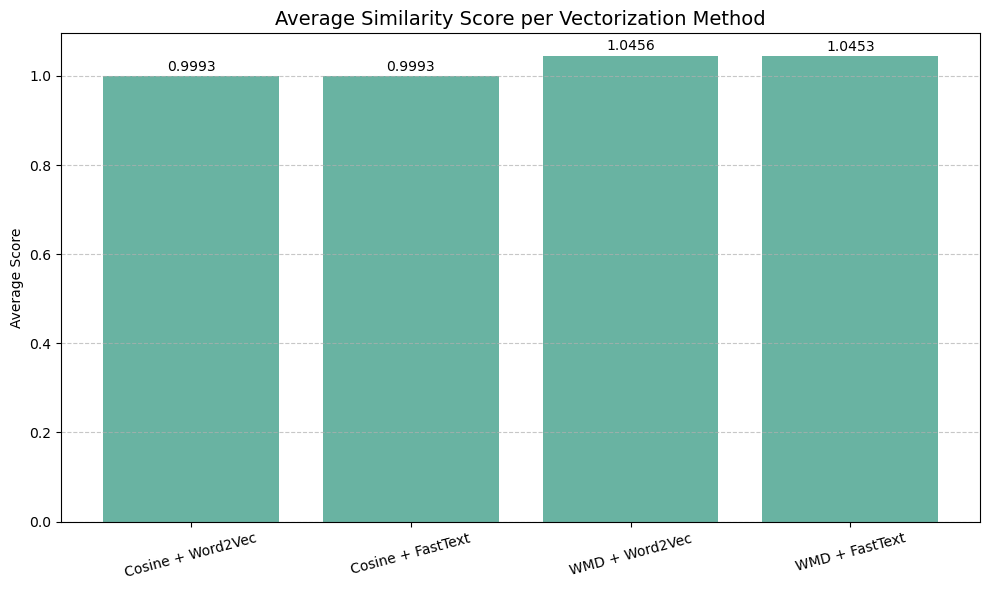

In [16]:
def average_score(results):
    all_scores = []
    for res in results:
        scores = [match['score'] for match in res['matches']]
        all_scores.extend(scores)
    return round(np.mean(all_scores), 4)

comparison_df = pd.DataFrame({
    "Method": ["Cosine + Word2Vec", "Cosine + FastText", "WMD + Word2Vec", "WMD + FastText"],
    "Average Similarity Score": [
        average_score(topk_w2v),
        average_score(topk_ft),
        average_score(results_wmd_w2v),
        average_score(results_wmd_ft)
    ]
})
print(comparison_df)

# bar chart comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df["Method"], comparison_df["Average Similarity Score"], color="#69b3a2")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

plt.title("Average Similarity Score per Vectorization Method", fontsize=14)
plt.ylabel("Average Score")
plt.ylim(0, max(comparison_df["Average Similarity Score"]) + 0.05)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


- Interpretasi:
Cosine + FastText dan Cosine + Word2Vec memberikan hasil yang sangat mirip namun cenderung terlalu umum. Sementara WMD, baik dengan Word2Vec maupun FastText, mampu menangkap konteks deskripsi pekerjaan secara lebih menyeluruh.

- Kesimpulan:
Model WMD + FastText menghasilkan rekomendasi yang lebih relevan dan bervariasi karena mempertimbangkan isi kalimat dan bentuk kata.

## Saving Vectorization & Similarity Results

In [22]:
def flatten_results(results, method_name):
    rows = []
    for res in results:
        for match in res['matches']:
            rows.append({
                "method": method_name,
                "job_source": res['job'],
                "job_category": res['category'],
                "matched_job": match['job_title'],
                "matched_category": match['category'],
                "similarity_score": match['score']
            })
    return pd.DataFrame(rows)

df_wmd_ft = flatten_results(results_wmd_ft, "WMD + FastText")

df_wmd_ft.to_csv("best_model_similarity_WMD_FastText.csv", index=False)
print("Hasil similarity dari model terbaik (WMD + FastText) berhasil disimpan ke 'best_model_similarity_WMD_FastText.csv'")

Hasil similarity dari model terbaik (WMD + FastText) berhasil disimpan ke 'best_model_similarity_WMD_FastText.csv'


In [23]:
df_wmd_ft

,method,job_source,job_category,matched_job,matched_category,similarity_score
0,WMD + FastText,data scientist financial conglomerates supervi...,analysis reporting banking financial services,data analyst data scientist nus office of data...,other education training,1.0346
1,WMD + FastText,data scientist financial conglomerates supervi...,analysis reporting banking financial services,data scientist project intern trust and safety...,businesssystems analysts information communica...,1.0366
2,WMD + FastText,data scientist financial conglomerates supervi...,analysis reporting banking financial services,data analyst,businesssystems analysts information communica...,1.0378
3,WMD + FastText,data scientist financial conglomerates supervi...,analysis reporting banking financial services,data analyst,engineering software information communication...,1.0380
4,WMD + FastText,data scientist,mathematics statistics information sciences sc...,data analyst,database development administration informatio...,1.0356
...,...,...,...,...,...,...
1135,WMD + FastText,assistant software engineer intern paid intern...,engineering software information communication...,data engineer financial services,engineering software information communication...,1.0504
1136,WMD + FastText,data science analyst information systems busin...,businesssystems analysts information communica...,data analyst,database development administration informatio...,1.0441
1137,WMD + FastText,data science analyst information systems busin...,businesssystems analysts information communica...,senior data scientist,developersprogrammers information communicatio...,1.0474
1138,WMD + FastText,data science analyst information systems busin...,businesssystems analysts information communica...,senior data engineer,engineering software information communication...,1.0523
